### 1. Preparing the data
* drop columns that are not needed
* inspect the data

In [21]:
import pandas as pd

df = pd.read_csv('music.csv')

df.drop(['artist', 'song', 'duration_ms', 'year', 'explicit', 'popularity'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2000 non-null   float64
 1   energy            2000 non-null   float64
 2   key               2000 non-null   int64  
 3   loudness          2000 non-null   float64
 4   mode              2000 non-null   int64  
 5   speechiness       2000 non-null   float64
 6   acousticness      2000 non-null   float64
 7   instrumentalness  2000 non-null   float64
 8   liveness          2000 non-null   float64
 9   valence           2000 non-null   float64
 10  tempo             2000 non-null   float64
 11  genre             2000 non-null   object 
dtypes: float64(9), int64(2), object(1)
memory usage: 187.6+ KB


### 2. Pairwise ralaionship between features

We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:
* It makes the model more complex, and more prone to overfitting.
* When our datasets are very large, using fewer features can drastically speed up our computation time.

In [22]:
corr_metrics = df.corr()
corr_metrics.style.background_gradient()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,-0.104038,0.032731,-0.033315,-0.067528,0.145590,-0.065429,0.023207,-0.126413,0.403178,-0.173418
energy,-0.104038,1.000000,-0.003446,0.651016,-0.040651,-0.057018,-0.445469,0.037861,0.156761,0.334474,0.153719
key,0.032731,-0.003446,1.000000,-0.007474,-0.153182,0.007147,0.002365,-0.008173,-0.033071,0.036977,-0.001431
loudness,-0.033315,0.651016,-0.007474,1.000000,-0.028133,-0.076388,-0.310039,-0.104925,0.102159,0.232150,0.080709
mode,-0.067528,-0.040651,-0.153182,-0.028133,1.000000,-0.000077,0.005744,-0.038613,0.025439,-0.074681,0.048434
speechiness,0.145590,-0.057018,0.007147,-0.076388,-0.000077,1.000000,0.000394,-0.062954,0.061172,0.073605,0.057747
acousticness,-0.065429,-0.445469,0.002365,-0.310039,0.005744,0.000394,1.000000,-0.005214,-0.110043,-0.128128,-0.103660
instrumentalness,0.023207,0.037861,-0.008173,-0.104925,-0.038613,-0.062954,-0.005214,1.000000,-0.034897,-0.015192,0.034608
liveness,-0.126413,0.156761,-0.033071,0.102159,0.025439,0.061172,-0.110043,-0.034897,1.000000,0.019040,0.028636
valence,0.403178,0.334474,0.036977,0.232150,-0.074681,0.073605,-0.128128,-0.015192,0.019040,1.000000,-0.025076


### 3. Spliting our data
As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track.

Once we have split the data into these arrays, we will perform some preprocessing steps to optimize our model development.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

features = df.drop(['genre'], axis=1).values
labels = df['genre'].values

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=10)

### 4. Normalizing the data

As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

### 5. PCA Analysis on scaled data

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

Text(0.5, 0, 'Principal Components #')

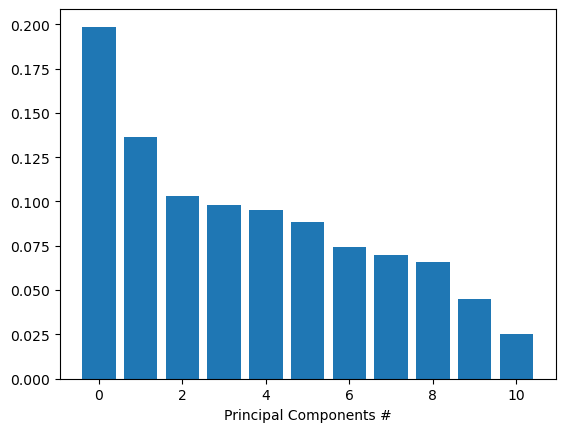

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(scaled_train_features)

exp_variances = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.bar(range(len(exp_variances)), exp_variances)
ax.set_xlabel('Principal Components #')

### 6. Further PCA Visualization

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

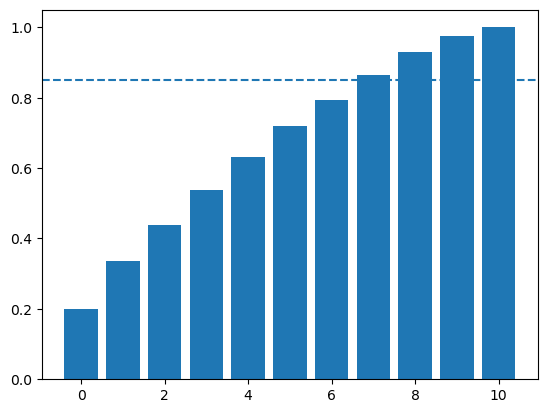

In [26]:
import numpy as np

cum_exp_variances = np.cumsum(exp_variances)

fig, ax = plt.subplots()
ax.bar(range(len(cum_exp_variances)), cum_exp_variances)
ax.axhline(y=0.85, linestyle='--')

### 7. Projecting on to our features

We saw from the plot that 7 features (remember indexing starts at 0) can explain 85% of the variance!

Therefore, we can use 7 components to perform PCA and reduce the dimensionality of our train and test features.

In [27]:
pca = PCA(n_components=7)

train_pca = pca.fit_transform(scaled_train_features)

test_pca = pca.transform(scaled_test_features)

### 8. Train decision tree to classify genres

Now we can use the lower dimensional PCA projection of the data to classify songs into genres.

Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.



In [28]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=10)

tree.fit(train_pca, train_labels)

pred_labels_tree = tree.predict(test_pca)

### 9. Compare our decision tree to a logistic regression
Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.

Sometimes simplest is best, and so we will start by applying logistic regression. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified).

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=10)

logreg.fit(train_pca, train_labels)

pred_labels_logit = logreg.predict(test_pca)

from sklearn.metrics import classification_report

class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree Classification Report: \n", class_rep_tree)


Decision Tree Classification Report: 
                                        precision    recall  f1-score   support

                     Dance/Electronic       0.00      0.00      0.00        11
                   Folk/Acoustic, pop       0.00      0.00      0.00         1
                                  R&B       0.00      0.00      0.00         4
           World/Traditional, hip hop       0.00      0.00      0.00         0
               World/Traditional, pop       0.00      0.00      0.00         1
         World/Traditional, rock, pop       0.00      0.00      0.00         0
                              country       0.00      0.00      0.00         3
                       easy listening       0.00      0.00      0.00         0
                              hip hop       0.15      0.20      0.17        20
            hip hop, Dance/Electronic       0.25      0.33      0.29         3
                         hip hop, R&B       0.00      0.00      0.00         0
            

/Users/mukhammadsobirov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mukhammadsobirov/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mukhammadsobirov/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWar

In [30]:
print("Logistic Regression Classification Report: \n", class_rep_log)

Logistic Regression Classification Report: 
                                        precision    recall  f1-score   support

                     Dance/Electronic       0.00      0.00      0.00        11
                   Folk/Acoustic, pop       0.00      0.00      0.00         1
                                  R&B       0.00      0.00      0.00         4
               World/Traditional, pop       0.00      0.00      0.00         1
                              country       0.00      0.00      0.00         3
                              hip hop       0.20      0.05      0.08        20
            hip hop, Dance/Electronic       0.00      0.00      0.00         3
                         hip hop, pop       0.24      0.32      0.27        60
       hip hop, pop, Dance/Electronic       0.33      0.05      0.08        22
                    hip hop, pop, R&B       0.21      0.11      0.14        45
                  hip hop, pop, latin       0.00      0.00      0.00         1
      

### 10. Balance our data for greater performance¶

Both models perform really poor... The dataset seems to be poor, so garbage in, garbage out. We can try to balance the data by oversampling the minority class.

In [34]:
hop_only = df.loc[df['genre'] == 'hip hop']
pop_only = df.loc[df['genre'] == 'pop']

pop_only = pop_only.sample(hop_only.shape[0], random_state=10)

hop_pop_bal = pd.concat([hop_only, pop_only])

features = hop_pop_bal.drop(['genre'], axis=1)
labels = hop_pop_bal['genre']

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

### 11. Does balancing the data help?

We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Hip hop" classification while retaining overall classification performance.

Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.

In [35]:
tree = DecisionTreeClassifier(random_state=10)

pred_labels_tree = tree.fit(train_pca, train_labels).predict(test_pca)

logreg = LogisticRegression(random_state=10)

pred_labels_logit = logreg.fit(train_pca, train_labels).predict(test_pca)

print("Decision Tree Classification Report: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression Classification Report: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree Classification Report: 
               precision    recall  f1-score   support

     hip hop       0.57      0.62      0.60        32
         pop       0.56      0.50      0.53        30

    accuracy                           0.56        62
   macro avg       0.56      0.56      0.56        62
weighted avg       0.56      0.56      0.56        62

Logistic Regression Classification Report: 
               precision    recall  f1-score   support

     hip hop       0.69      0.62      0.66        32
         pop       0.64      0.70      0.67        30

    accuracy                           0.66        62
   macro avg       0.66      0.66      0.66        62
weighted avg       0.66      0.66      0.66        62



### 12. Using cross-validation to evaluate our models
Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

Before we can perform cross-validation we will need to create pipelines to scale our data, perform PCA, and instantiate our model of choice - DecisionTreeClassifier or LogisticRegression.

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as K-fold CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [36]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

kf = KFold(n_splits=10, shuffle=True, random_state=10)

tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

print("DecisionTree:", tree_score.mean(), "Logistic Regression:", logit_score.mean())

DecisionTree: 0.6491666666666667 Logistic Regression: 0.7503333333333334
